In [16]:
import numpy as np
import pandas as pd
from pandas import Timedelta
from functools import reduce
import warnings
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from scipy import signal
%matplotlib inline

# If you want a style choose one
#plt.style.use('Solarize_Light2')
#plt.style.use('tableau-colorblind10')
NF_ORANGE = '#ff5a36'
NF_BLUE = '#163251'

In [2]:
# Loading the raw final DataFrame
df = pd.read_csv(r'data\Data_imputed_2019_to_2025.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96336 entries, 0 to 96335
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              96336 non-null  object 
 1   year              96336 non-null  int64  
 2   month             96336 non-null  int64  
 3   day               96336 non-null  int64  
 4   dayofyear         96336 non-null  int64  
 5   hour              96336 non-null  int64  
 6   week              96336 non-null  int64  
 7   dayofweek         96336 non-null  int64  
 8   price             96336 non-null  float64
 9   period_start_utc  96336 non-null  object 
 10  period_end_utc    96336 non-null  object 
 11  c_by_hour         96336 non-null  int64  
 12  load_forecast_da  95280 non-null  float64
 13  load_actual       96327 non-null  float64
 14  off_wind_da       96336 non-null  float64
 15  off_wind_act      96336 non-null  float64
 16  on_wind_da        96336 non-null  float6

In [5]:
df.isna().sum()

date                    0
year                    0
month                   0
day                     0
dayofyear               0
hour                    0
week                    0
dayofweek               0
price                   0
period_start_utc        0
period_end_utc          0
c_by_hour               0
load_forecast_da     1056
load_actual             9
off_wind_da             0
off_wind_act            0
on_wind_da              0
on_wind_act            48
solar_da                0
solar_act              48
gen_forecast_da     32735
gen_actual              0
res_sum_da              0
res_sum_act             0
imputed                 0
interpolated            0
dtype: int64

In [7]:
# Converting date columns to datetime and filtering for 2019-2020 period

df['date'] = pd.to_datetime(df['date'])
df['period_start_utc'] = pd.to_datetime(df['period_start_utc'])

start_date_df = '2019-01-01'
end_date_df = '2025-12-31'
df = df.query("date >= @start_date_df")
df = df.query("date <= @end_date_df")
df['load_forecast_da'].isna().sum()
df.tail()

,date,year,month,day,dayofyear,hour,week,dayofweek,price,period_start_utc,...,on_wind_da,on_wind_act,solar_da,solar_act,gen_forecast_da,gen_actual,res_sum_da,res_sum_act,imputed,interpolated
96331,2025-12-31,2025,12,31,365,18,1,2,95.9900,2025-12-31 18:00:00+00:00,...,25289.8075,26949.3850,0.0,0.0675,58900.9800,60292.3475,30719.8550,32367.9425,0,0
96332,2025-12-31,2025,12,31,365,19,1,2,86.8025,2025-12-31 19:00:00+00:00,...,26179.9500,28002.9700,0.0,0.0525,58562.3375,58865.2100,31674.9400,33018.0750,0,0
96333,2025-12-31,2025,12,31,365,20,1,2,79.7975,2025-12-31 20:00:00+00:00,...,27294.2850,29909.6650,0.0,0.0575,57650.8775,59417.6050,32653.3850,34299.7800,0,0
96334,2025-12-31,2025,12,31,365,21,1,2,81.3900,2025-12-31 21:00:00+00:00,...,27876.2850,29905.7425,0.0,0.0400,56819.4225,59089.8875,33265.3650,33269.7175,0,0
96335,2025-12-31,2025,12,31,365,22,1,2,78.5700,2025-12-31 22:00:00+00:00,...,29243.1850,31084.6075,0.0,0.0450,56897.7500,58908.9675,34730.7275,33799.4275,0,0


In [8]:
# Ensure timestamp index
df.set_index('period_start_utc', inplace=True)

Text(0.5, 1.0, 'Day-Ahead Energy Prices in 2019-2025')

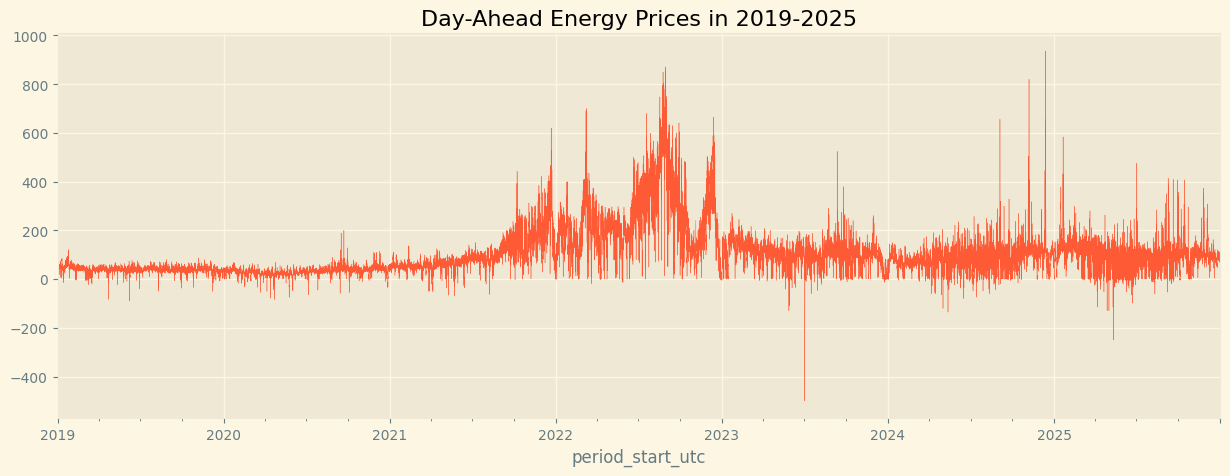

In [21]:
df['price'].plot(figsize=(15, 5), color=NF_ORANGE, linewidth=0.3)
plt.title('Day-Ahead Energy Prices in 2019-2025')

## SARIMAX ##

In [22]:
# One hot encoding for month and year columns

month_dummies = pd.get_dummies(df['month'], prefix='month', drop_first=True)
df = pd.concat([df, month_dummies], axis=1)

year_dummies = pd.get_dummies(df['year'], prefix='year', drop_first=True)
df = pd.concat([df, year_dummies], axis=1)

df.columns

Index(['date', 'year', 'month', 'day', 'dayofyear', 'hour', 'week',
       'dayofweek', 'price', 'period_end_utc', 'c_by_hour', 'load_forecast_da',
       'load_actual', 'off_wind_da', 'off_wind_act', 'on_wind_da',
       'on_wind_act', 'solar_da', 'solar_act', 'gen_forecast_da', 'gen_actual',
       'res_sum_da', 'res_sum_act', 'imputed', 'interpolated', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12', 'year_2020', 'year_2021',
       'year_2022', 'year_2023', 'year_2024', 'year_2025'],
      dtype='object')

In [ ]:
# 2. Replace load + RES by residual load

df["residual_load"] = (
    df["load_forecast_da"]
    - df["off_wind_da"]
    - df["on_wind_da"]
    - df["solar_da"]
)

In [ ]:
# Define target variable and exogenous variables

# Target
y = df["price"]

# Exogenous variables
exog = df[["residual_load", 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12', 'year_2020', 'year_2021',
       'year_2022', 'year_2023', 'year_2024', 'year_2025']]

exog.head()

In [ ]:
# Define the exact point where training ends and testing begins
split_point = "2025-11-30 23:00:00" # The exact last train hour

y_train = y[:split_point]
exog_train = exog[:split_point]

# For test use a slice that starts immediately after
y_test = y[split_point:].iloc[1:] 
exog_test = exog[split_point:].iloc[1:]

In [ ]:
# Convert all exogenous columns to float to ensure NumPy compatibility
exog_train = exog_train.astype(float)
exog_test = exog_train.astype(float)

# Set the frequency explicitly
y_train = y_train.asfreq('H')
exog_train = exog_train.asfreq('H')

# Now run the SARIMAX model

model = SARIMAX(
    y_train,
    exog=exog_train,
    order=(1,0,1),
    seasonal_order=(1,0,1,24),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit()
print(results.summary())


e:\nf_repo\ai-for-energy\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
e:\nf_repo\ai-for-energy\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
e:\nf_repo\ai-for-energy\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                              price   No. Observations:                60624
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 24)   Log Likelihood             -240333.565
Date:                            Fri, 13 Feb 2026   AIC                         480707.129
Time:                                    17:35:35   BIC                         480887.370
Sample:                                01-01-2019   HQIC                        480763.089
                                     - 11-30-2025                                         
Covariance Type:                              opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
load_forecast_da     0.0030   4.97e-05     60.382      0.000       0.003       0.003
off_wind_da      

Text(0.5, 1.0, '2019-25 SARIMAX Forecast of Day-Ahead Energy Prices for 01.12.2025 (Next 24 Hours)')

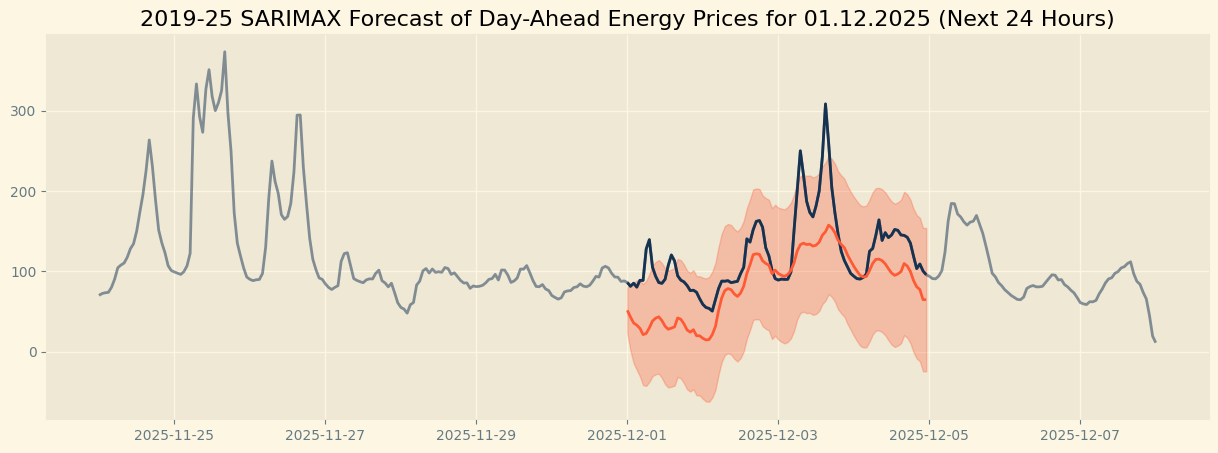

In [ ]:
# Forecast next-day hourly prices for 01.12.2025

n_steps = 96

forecast = results.get_forecast(
    steps=n_steps,
    exog=exog_test.iloc[:n_steps] # This defines the FUTURE exogenous values for the forecasted period
)

y_pred = forecast.predicted_mean
conf_int = forecast.conf_int()

# Actual curve and the results

actual_values = y_test.loc[y_pred.index]

# Graph window period

start_plot_date = y_test.index[0] - pd.Timedelta(days=7)  # Show 7 days of history
end_plot_date = y_test.index[0] + pd.Timedelta(days=7)  # Show 1 day of forecast and 6 days after to see the curve
y_slice = y[start_plot_date:end_plot_date]  # Historical data up to the start of the test set

# Plotting

plt.figure(figsize=(15, 5))
plt.plot(y_slice.index, y_slice, label='Historical', color=NF_BLUE, alpha=0.5)
plt.plot(actual_values.index, actual_values, label='Actual', color=NF_BLUE)
plt.plot(y_pred.index, y_pred, label='Predicted', color=NF_ORANGE)
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color=NF_ORANGE, alpha=0.3, label='Confidence Interval')
plt.title('2019-25 SARIMAX Forecast of Day-Ahead Energy Prices for 01.12.2025 (Next 24 Hours)')

#### ARIMA

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Now run the ARIMA model

model_arima = ARIMA(y_train)

results_arima = model_arima.fit()
print(results_arima.summary())


e:\nf_repo\ai-for-energy\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
e:\nf_repo\ai-for-energy\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
e:\nf_repo\ai-for-energy\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                16800
Model:                          ARIMA   Log Likelihood              -71026.110
Date:                Wed, 11 Feb 2026   AIC                         142056.220
Time:                        13:44:37   BIC                         142071.678
Sample:                    01-01-2019   HQIC                        142061.321
                         - 11-30-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         33.8434      0.135    251.548      0.000      33.580      34.107
sigma2       275.2520      1.498    183.799      0.000     272.317     278.187
Ljung-Box (L1) (Q):               15003.90   Jarque-

Text(0.5, 1.0, 'ARIMA Forecast of Day-Ahead Energy Prices (Next 24 Hours)')

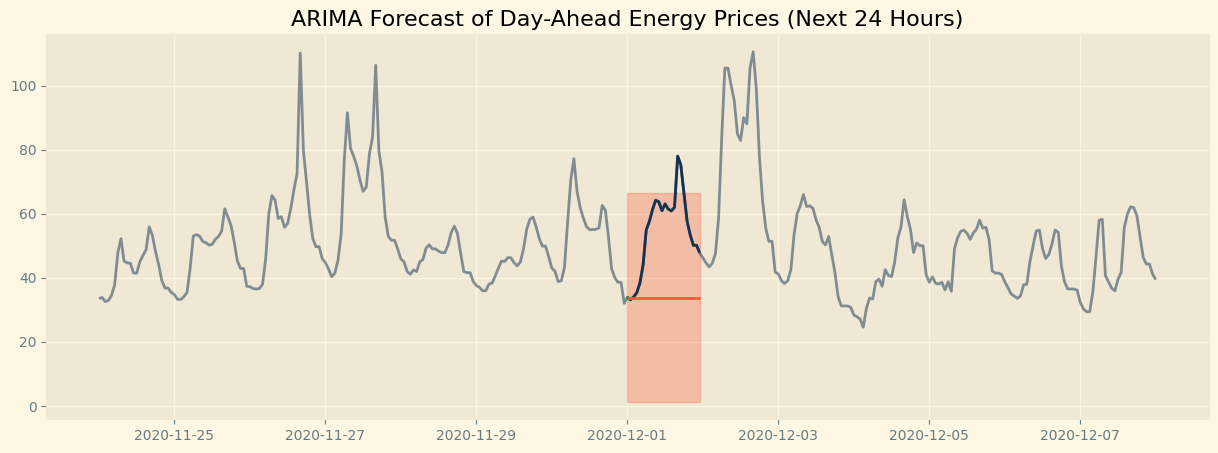

In [ ]:
# Forecast next-day hourly prices with ARIMA model

n_steps = 24

forecast_arima = results_arima.get_forecast(
    steps=n_steps
)

y_pred_arima = forecast_arima.predicted_mean
conf_int_arima = forecast_arima.conf_int()

# Plotting actual curne and the results

actual_values = y_test.loc[y_pred_arima.index]

plt.figure(figsize=(15, 5))
plt.plot(y_slice.index, y_slice, label='Historical', color=NF_BLUE, alpha=0.5)
plt.plot(actual_values.index, actual_values, label='Actual', color=NF_BLUE)
plt.plot(y_pred_arima.index, y_pred_arima, label='Predicted', color=NF_ORANGE)
plt.fill_between(conf_int_arima.index, conf_int_arima.iloc[:, 0], conf_int_arima.iloc[:, 1], color=NF_ORANGE, alpha=0.3, label='Confidence Interval')
plt.title('ARIMA Forecast of Day-Ahead Energy Prices (Next 24 Hours)')

#### Model comparison ##

|Metric        | SARIMAX    | ARIMA     | Interpretation |
|--------------|------------|-----------|----------------|
|Log-Likelihood|"−30,910.8" |"−43,232.7"|Higher is better. SARIMAX fits the data much more closely.|
|AIC           |"61,839.6"  |"86,469.4" |"Lower is better. A difference of >10 is significant; ~25,000 is massive."|
|BIC           |"61,902.5"  |"86,483.4" |Lower is better. SARIMAX is preferred even after penalizing for more parameters.|
|σ2 (Error Variance)|"158.35"|"2,827.57"|Lower is better. SARIMAX has  94% less unexplained variance.|

In [ ]:
# Assessing the models with RMSE, MAPE and MAE

rms_sarimax = np.sqrt(mean_squared_error(y_test[:n_steps], y_pred))
rms_arima = np.sqrt(mean_squared_error(y_test[:n_steps], y_pred_arima))

mape_sarimax = mean_absolute_percentage_error(y_test[:n_steps], y_pred) * 100
mape_arima = mean_absolute_percentage_error(y_test[:n_steps], y_pred_arima) * 100

mae_sarimax = np.mean(np.abs(y_test[:n_steps] - y_pred))
mae_arima = np.mean(np.abs(y_test[:n_steps] - y_pred_arima))


# Printing RMSE of all the methods
print("RMSE of all the methods")
print("SARIMAX: ", round(rms_sarimax,3))
print("ARIMA: ", round(rms_arima,3))
print("MAPE of all the methods")
print("SARIMAX: ", round(mape_sarimax,3))
print("ARIMA: ", round(mape_arima,3))
print("MAE of all the methods")
print("SARIMAX: ", round(mae_sarimax,3))
print("ARIMA: ", round(mae_arima,3))

RMSE of all the methods
SARIMAX:  4.592
ARIMA:  24.133
MAPE of all the methods
SARIMAX:  7.943
ARIMA:  34.135
MAE of all the methods
SARIMAX:  4.115
ARIMA:  20.707


In [26]:
# Assessing the model with RMSE, MAPE and MAE

rms_sarimax_improved = np.sqrt(mean_squared_error(y_test[:n_steps], y_pred))
mape_sarimax_improved = mean_absolute_percentage_error(y_test[:n_steps], y_pred) * 100
mae_sarimax_improved = np.mean(np.abs(y_test[:n_steps] - y_pred))
print("Improved SARIMAX RMSE: ", round(rms_sarimax_improved,3))
print("Improved SARIMAX MAPE: ", round(mape_sarimax_improved,3), "%")
print("Improved SARIMAX MAE: ", round(mae_sarimax_improved,3))

Improved SARIMAX RMSE:  3.943
Improved SARIMAX MAPE:  6.399 %
Improved SARIMAX MAE:  3.202


### SARIMAX-GARCH extension (volatility modelling)